## Setup

Run the commands below and manually install the KD_Lib library; Note that unstalling it directly from pip will fail due to an [open issue](https://github.com/SforAiDl/KD_Lib/issues/108).

In [ ]:
!git clone https://github.com/SforAiDl/KD_Lib.git
%cd KD_Lib

fatal: destination path 'KD_Lib' already exists and is not an empty directory.
/content/KD_Lib


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing KD_Lib.egg-info/PKG-INFO
writing dependency_links to KD_Lib.egg-info/dependency_links.txt
writing requirements to KD_Lib.egg-info/requires.txt
writing top-level names to KD_Lib.egg-info/top_level.txt
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
reading manifest template 'MANIFEST.in'
writing manifest file 'KD_Lib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/KD_Lib
creating build/bdist.linux-x86_64/egg/KD_Lib/Quantization
creating build/bdist.linux-x86_64/egg/KD_Lib/Quantization/qat
copying build/lib/KD_Lib/Quantization/qat/qat.py -> build/bdist.linux-x86_64/egg/KD_Lib/Quantization/qat
copying build/lib/KD_Lib/Quantization/qat/__init__.py -> build/bdist.linux-x86_64/egg/KD_Lib/Quantization/qat
creating build/bdist.linux-x86_64/egg/KD_Lib/Quantization/dynamic
copying bu

In [ ]:
%cd ..

/content


**NOTE:** You now need to restart the runtime and re-execute the cells above, then the following cell should work:

In [ ]:
# this should now work
from KD_Lib.KD import VanillaKD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
from pprint import pprint

import cifar100_helper  # local file, needs to be manually uploaded to Colab

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision

from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                             ConfusionMatrixDisplay)

In [ ]:
# Use this to view all the available models
# pprint(torch.hub.list("chenyaofo/pytorch-cifar-models", force_reload=True))
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=True)
teacher_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
# we need 1 worker each for train/test since colab only has 2 processers
train_loader, test_loader = cifar100_helper.cifar100("./", 32, None, None, batch_size=128, num_workers=1, is_vit=True)


Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
idx_to_class = {v:k for k, v in train_loader.dataset.class_to_idx.items()}
idx_to_class_vec = np.array(list(idx_to_class.values()))

In [ ]:
# functions to show an image
def imshow(img, to_numpy=True):
    img = img / 2 + 0.5     # unnormalize
    if to_numpy:
        npimg = img.numpy()
    else:
        npimg = img
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return img

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [ ]:
def print_acc(model, loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f'Accuracy of the network on the {len(loader.dataset)} test images: %d %%' % (100 * correct / total))

In [ ]:
# results for our model
print("teacher model ", end="")
print_acc(teacher_model, test_loader)
print("student model ", end="")
print_acc(student_model, test_loader)

teacher model Accuracy of the network on the 10000 test images: 65 %
student model Accuracy of the network on the 10000 test images: 61 %


## Knowledge Distilation

In [ ]:
import torch.optim as optim

# These values are the same from the original training of our teacher model
# https://github.com/chenyaofo/image-classification-codebase/blob/master/conf/cifar10.conf
# Note that although the file is for CIFAR-10, the CIFAR-100 file inherits theses parameters.
optim_dict = dict(
    lr=0.01,
    momentum=0.9,
    dampening=0,
    weight_decay=5e-4,
    nesterov=True,
)


student_optimizer = optim.SGD(student_model.parameters(), **optim_dict)
# we don't use this optimizer since we end up training just the student,
# but we must pass in a valid value
teacher_optimizer = optim.SGD(student_model.parameters(), **optim_dict)

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Viz4ML/"

In [ ]:
%%time
from KD_Lib.KD import VanillaKD
# Now, this is where KD_Lib comes into the picture
distiller = VanillaKD(
    teacher_model, student_model, train_loader, test_loader, teacher_optimizer, student_optimizer,
    temp=10.0, distil_weight=0.5, device="cuda", log=True, logdir=BASE_DIR + "logs2/",
)
distiller.evaluate(teacher=False)                                       # Evaluate the student network
distiller.get_parameters()                  

--------------------------------------------------------------------------------
Accuracy: 0.624
--------------------------------------------------------------------------------
Total parameters for the teacher network are: 861620
Total parameters for the student network are: 278324
CPU times: user 1.05 s, sys: 61 ms, total: 1.11 s
Wall time: 2.41 s


Training Student...
Epoch: 1, Loss: 379.5515025854111, Accuracy: 0.49812
Epoch: 2, Loss: 375.2631215453148, Accuracy: 0.50078
Epoch: 3, Loss: 373.1710253357887, Accuracy: 0.50396
Epoch: 4, Loss: 366.4204389452934, Accuracy: 0.51182
Epoch: 5, Loss: 364.2520188689232, Accuracy: 0.51496
Epoch: 6, Loss: 360.82195138931274, Accuracy: 0.51592
Epoch: 7, Loss: 361.0583602786064, Accuracy: 0.51766
Epoch: 8, Loss: 357.27905863523483, Accuracy: 0.52084
Epoch: 9, Loss: 355.2666702270508, Accuracy: 0.52524
Epoch: 10, Loss: 356.37198066711426, Accuracy: 0.52178
Epoch: 11, Loss: 353.6566960811615, Accuracy: 0.52862
Epoch: 12, Loss: 351.7804194688797, Accuracy: 0.5271
Epoch: 13, Loss: 352.46156537532806, Accuracy: 0.52828
Epoch: 14, Loss: 353.37105745077133, Accuracy: 0.52636
Epoch: 15, Loss: 350.1725154519081, Accuracy: 0.5312
Epoch: 16, Loss: 351.61070615053177, Accuracy: 0.53042
Epoch: 17, Loss: 349.5306414961815, Accuracy: 0.53276
Epoch: 18, Loss: 351.96029740571976, Accuracy: 0.52796
Epoch: 19, L

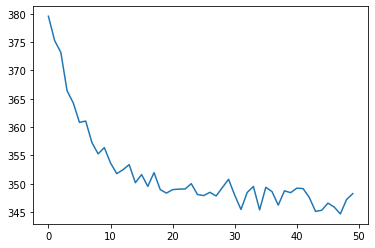

In [34]:
distiller.train_student(epochs=50, plot_losses=True, save_model=True)    # Train the student network
distiller.evaluate(teacher=False)                                       # Evaluate the student network
torch.save(distiller.student_model.state_dict(), BASE_DIR + "student_model_50_epoch.pt")

In [35]:
# optional: train it for another 50 epochs, totataling 100.
# distiller.train_student(epochs=50, plot_losses=True, save_model=True)    # Train the student network
# torch.save(distiller.student_model.state_dict(), BASE_DIR + "student_model_100_epoch.pt")

In [52]:
# get some random test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.cuda()

## Log results/metrics for this single batch 

Write metrics

In [53]:
# from https://github.com/ryanchankh/cifar100coarse
def sparse2coarse(targets):
    """Convert Pytorch CIFAR100 sparse targets to coarse targets.
    Usage:
        trainset = torchvision.datasets.CIFAR100(path)
        trainset.targets = sparse2coarse(trainset.targets)
    """
    coarse_labels = np.array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,  
                               3, 14,  9, 18,  7, 11,  3,  9,  7, 11,
                               6, 11,  5, 10,  7,  6, 13, 15,  3, 15,  
                               0, 11,  1, 10, 12, 14, 16,  9, 11,  5, 
                               5, 19,  8,  8, 15, 13, 14, 17, 18, 10, 
                               16, 4, 17,  4,  2,  0, 17,  4, 18, 17, 
                               10, 3,  2, 12, 12, 16, 12,  1,  9, 19,  
                               2, 10,  0,  1, 16, 12,  9, 13, 15, 13, 
                              16, 19,  2,  4,  6, 19,  5,  5,  8, 19, 
                              18,  1,  2, 15,  6,  0, 17,  8, 14, 13])
    return coarse_labels[targets]

In [54]:
idx_to_class20 = {i:x for i,x in enumerate([
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 'household furniture', 'insects', 
     'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates', 
    'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
])}

In [81]:
def save_results(labels, predicted, name):
    results = classification_report(labels, predicted, output_dict=True)
    print(results)
    results = {idx_to_class[int(k)]: v for k,v in results.items() if k.isnumeric()}

    with open(BASE_DIR + f'{name}_metrics.json', 'w') as fp:
        json.dump(results, fp, sort_keys=True, indent=4)
        
    with open(BASE_DIR + f'{name}_accuracy.json', 'w') as fp:
        json.dump({"accuracy": accuracy_score(labels, predicted)}, fp)

    cm = pd.DataFrame(confusion_matrix(labels, predicted), columns=idx_to_class.values(), index=idx_to_class.values())
    cm.to_json(BASE_DIR + f"{name}_confusion_matrix_100.json", indent=True)

    # Now for the 20 classes version correlation:
    cm = pd.DataFrame(confusion_matrix(sparse2coarse(labels), sparse2coarse(predicted)), 
                        columns=idx_to_class20.values(), index=idx_to_class20.values())
    cm.to_json(BASE_DIR + f"{name}_confusion_matrix_20.json", indent=True)

In [75]:
# teacher
predicted, labels = [], []
for idx, (batch_x, batch_y) in enumerate(test_loader):
    outputs = teacher_model(batch_x.cuda())
    _, preds = torch.max(outputs, 1)
    predicted += preds.cpu().flatten().tolist()
    labels += batch_y.flatten().tolist()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [76]:
save_results(labels, predicted, "teacher")

In [82]:
# student
predicted, labels = [], []
for idx, (batch_x, batch_y) in enumerate(test_loader):
    outputs = distiller.student_model(batch_x.cuda())
    _, preds = torch.max(outputs, 1)
    predicted += preds.cpu().flatten().tolist()
    labels += batch_y.flatten().tolist()
        
save_results(labels, predicted, "student")

{'0': {'precision': 0.9024390243902439, 'recall': 0.74, 'f1-score': 0.8131868131868132, 'support': 100}, '1': {'precision': 0.8452380952380952, 'recall': 0.71, 'f1-score': 0.7717391304347825, 'support': 100}, '2': {'precision': 0.6666666666666666, 'recall': 0.54, 'f1-score': 0.5966850828729282, 'support': 100}, '3': {'precision': 0.6551724137931034, 'recall': 0.19, 'f1-score': 0.29457364341085274, 'support': 100}, '4': {'precision': 0.3865546218487395, 'recall': 0.46, 'f1-score': 0.4200913242009133, 'support': 100}, '5': {'precision': 0.6666666666666666, 'recall': 0.62, 'f1-score': 0.6424870466321244, 'support': 100}, '6': {'precision': 0.7368421052631579, 'recall': 0.56, 'f1-score': 0.6363636363636364, 'support': 100}, '7': {'precision': 0.7183098591549296, 'recall': 0.51, 'f1-score': 0.5964912280701754, 'support': 100}, '8': {'precision': 0.8414634146341463, 'recall': 0.69, 'f1-score': 0.7582417582417583, 'support': 100}, '9': {'precision': 0.8461538461538461, 'recall': 0.66, 'f1-sco

In [80]:
len(labels)

10000

## Generate feature maps

The visualization code from [utkuozbulak/pytorch-cnn-visualizations](https://github.com/utkuozbulak/pytorch-cnn-visualizations#gradient-visualization) did not work to the model not being currently supported; see [this](https://github.com/utkuozbulak/pytorch-cnn-visualizations/issues/82) issue

In [58]:
!pip install medcam

     |████████████████████████████████| 47.4MB 64kB/s 
     |████████████████████████████████| 81kB 12.4MB/s 


In [59]:
# Import M3d-CAM
from medcam import medcam
from torchvision.utils import save_image

In [67]:
%time
amount = 100

# !rm attention_maps/ -r
# !rm images/ -r
# !mkdir images

# We must use batch_size = 1 for this to work
temp_loader = cifar100_helper.cifar100("./", 32, None, None, batch_size=1, num_workers=1, is_vit=True, shuffle=False)[1]
model1 = medcam.inject(teacher_model, output_dir=BASE_DIR + "teacher_attention_maps", save_maps=True, backend="gbp", )
model2 = medcam.inject(distiller.student_model, output_dir=BASE_DIR + "student_attention_maps", save_maps=True, 
                      backend="gbp")


model.eval()
for idx, (batch_x, batch_y) in enumerate(temp_loader):
    if idx == amount:
        break
    # Every time forward is called, attention maps will be generated and saved in the directory "attention_maps"
    save_image(batch_x[0].detach(), BASE_DIR + f"images/{idx}.png")
    output = model1(batch_x.cuda())
    output = model2(batch_x.cuda())

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 12.9 µs
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
